In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

%matplotlib inline

from pylab import rcParams

clusers_num =3
rcParams['figure.figsize'] = 15, 15

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import glob

fpaths = glob.glob('/data/RoadDamage/data/all/JPEGImages/*.jpg')

#image_list = []

N = len(fpaths)

print(N)
data = np.empty((N, 10000,3), dtype=np.uint8)

for i,fpath in enumerate(fpaths):
    image = cv2.imread(fpath, cv2.COLOR_BGR2HSV)
    
    
    image = cv2.resize(image, (100,100), interpolation=cv2.INTER_AREA)
    
    Z = image.reshape((-1,3))
    
    data[i, ...] = np.uint8(Z)

Using TensorFlow backend.


11653


KeyboardInterrupt: 

In [ ]:
print(data.shape)
data = data.reshape(-1,3)
print(data.shape)

gmm_pixel = GaussianMixture(n_components=clusers_num,covariance_type='diag')
gmm_pixel.fit(data)

In [3]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    for i in range(len(labels)):
        if labels[i] == 0:
            labels[i]=1
        else:
            labels[i]=0

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [8]:
import itertools

def getFilenames(exts):
    fnames = [glob.glob(ext) for ext in exts]
    fnames = list(itertools.chain.from_iterable(fnames))
    return fnames

exts = ["/data/RoadDamage/data/all/JPEGImages/*.jpg"]
res = getFilenames(exts)

tmp_list = []

for tmp_img in res:
    img = cv2.imread(tmp_img,cv2.COLOR_BGR2HSV)
    
    img_shape = img.reshape((-1,3))

    tmp_pixel = gmm_pixel.predict(img_shape)
    
    a = 0
    b = 0
    c = 0
    for x in tmp_pixel:
        if x == 0:
            a+=1
        elif x==1:
            b+=1
        elif x==2:
            c+=1

            
    tmp_list.append([a,b,c])

In [9]:
tmp_list =np.array(tmp_list)
tmp_list = tmp_list[:, ::-1] #交换列是为了方便画图

#print(tmp_list)

gmm_image = GaussianMixture(n_components=clusers_num).fit(tmp_list)



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import os
from matplotlib import animation 

def visualize_3d_gmm(points, w, mu, stdev, export=True):
    '''
    plots points and their corresponding gmm model in 3D
    Input: 
        points: N X 3, sampled points
        w: n_gatwo_list, gmm weights
        mu: 3 X n_gaussians, gmm means
        stdev: 3 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''

    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')
    axes.set_xlim([0, 300])
    axes.set_ylim([0, 300])
    axes.set_zlim([0, 300])
    plt.set_cmap('Set1')
    #colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    colors = ['red','blue','green']
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
        plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)
    plt.title('3D GMM')
    axes.set_xlabel('S')
    axes.set_ylabel('V')
    axes.set_zlabel('H')
    axes.view_init(35.246, 45)
    def rotate(angle): 
        axes.view_init(azim=angle) 
    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/3D_GMM_demonstration_pd3_test.png', dpi=100, format='png')
        
        rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100) 
        rot_animation.save('images/rotation_pd3_test.gif', dpi=80, writer='imagemagick') 

    plt.show()
    
    
    
def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=10, ax=None, sigma_multiplier=3):
    '''
        plot a sphere surface
        Input: 
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)

    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)

    return ax

def visualize_2D_gmm(points, w, mu, stdev, export=True):
    '''
    plots points and their corresponding gmm model in 2D
    Input: 
        points: N X 2, sampled points
        w: n_gaussians, gmm weights
        mu: 2 X n_gaussians, gmm means
        stdev: 2 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''
    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = plt.gca()
    axes.set_xlim([0, 1])
    axes.set_ylim([-1, 1])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        plt.scatter(points[idx, 0], points[idx, 1], alpha=0.5, c=colors[i])
        for j in range(8):
            axes.add_patch(
                patches.Ellipse(mu[:, i], width=(j+1) * stdev[0, i], height=(j+1) *  stdev[1, i], fill=False, color=[0.0, 0.0, 1.0, 1.0/(0.5*j+1)]))
        plt.title('GMM')
    plt.xlabel('X')
    plt.ylabel('Y')

    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/2D_GMM_demonstration.png', dpi=100, format='png')

    plt.show()

1834
855
7311


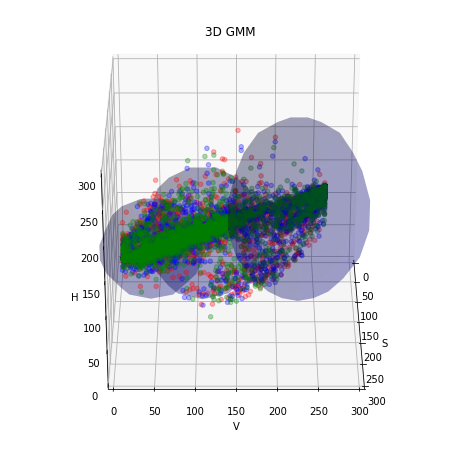

In [13]:
import random

plot_size = 10000

plot_tmp_list = []

one_list=0
zero_list=0
two_list = 0
for i in range(0,plot_size):
    random_i = random.randint(0,len(data))
    
    plot_tmp_list.append(data[random_i])
    
    if gmm_pixel.predict([data[i]]) ==0:
        zero_list+=1
    elif gmm_pixel.predict([data[i]]) ==1:
        one_list+=1
    elif gmm_pixel.predict([data[i]]) ==2:
        two_list +=1
print(zero_list)
print(one_list)
print(two_list)

visualize_3d_gmm(np.array(plot_tmp_list), gmm_pixel.weights_, gmm_pixel.means_.T, np.sqrt(gmm_pixel.covariances_).T)

In [15]:
import pickle

pickle.dump(gmm_pixel, open('gmm_roadCrack_checkmodel/gmm_pixel_pd3.pkl', 'wb'))
pickle.dump(gmm_image, open('gmm_roadCrack_checkmodel/gmm_image_pd3.pkl', 'wb'))


In [47]:
type(data)

numpy.ndarray

In [48]:
type(plot_tmp_list)

list

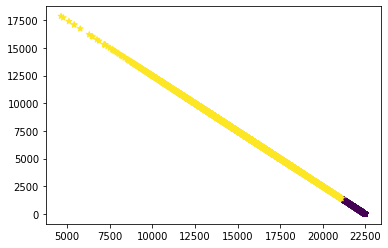

In [14]:
labels = gmm_image.predict(tmp_list)

tmp_list = tmp_list[:, ::-1] #交换列是为了方便画图

plt.scatter(tmp_list[:, 0], tmp_list[:, 1], c=labels, marker='*', cmap='viridis');